<a href="https://colab.research.google.com/github/rociotarda/TP1---Datos/blob/main/analisis_exploratorio_martin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# importacion general de librerias y de visualizacion (matplotlib y seaborn)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

plt.style.use('default') # haciendo los graficos un poco mas bonitos en matplotlib
#plt.rcParams['figure.figsize'] = (20, 10)

sns.set(style="whitegrid") # seteando tipo de grid en seaborn

pd.options.display.float_format = '{:20,.2f}'.format # suprimimos la notacion cientifica en los outputs

import warnings
warnings.filterwarnings('ignore')

In [2]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [3]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [4]:
id='1Su8VBZNHOqwzBIA_-hiMtUdhS6-p6Kte'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('train_values.csv')

In [5]:
id_2='1ct-Uk6jmJWZ4-g-ryvCINzDSmLsRYBlN'
downloaded = drive.CreateFile({'id': id_2})
downloaded.GetContentFile('train_labels.csv')

In [6]:
train_values = pd.read_csv('train_values.csv')
train_labels = pd.read_csv('train_labels.csv')

#Análisis previo sobre el DataFrame train_values.



In [ ]:
train_values.head(5)

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
0,802906,6,487,12198,2,30,6,5,t,r,n,f,q,t,d,1,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
1,28830,8,900,2812,2,10,8,7,o,r,n,x,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
2,94947,21,363,8973,2,10,5,5,t,r,n,f,x,t,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
3,590882,22,418,10694,2,10,6,5,t,r,n,f,x,s,d,0,1,0,0,0,0,1,1,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
4,201944,11,131,1488,3,30,8,9,t,r,n,f,x,s,d,1,0,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
#Nos fijamos información relevante sobre los datos del DataFrame 
train_values.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260601 entries, 0 to 260600
Data columns (total 39 columns):
 #   Column                                  Non-Null Count   Dtype 
---  ------                                  --------------   ----- 
 0   building_id                             260601 non-null  int64 
 1   geo_level_1_id                          260601 non-null  int64 
 2   geo_level_2_id                          260601 non-null  int64 
 3   geo_level_3_id                          260601 non-null  int64 
 4   count_floors_pre_eq                     260601 non-null  int64 
 5   age                                     260601 non-null  int64 
 6   area_percentage                         260601 non-null  int64 
 7   height_percentage                       260601 non-null  int64 
 8   land_surface_condition                  260601 non-null  object
 9   foundation_type                         260601 non-null  object
 10  roof_type                               260601 non-null 

In [ ]:
#Nos fijamos si faltan datos en las columnas
train_values.isnull().value_counts()

building_id  geo_level_1_id  geo_level_2_id  geo_level_3_id  count_floors_pre_eq  age    area_percentage  height_percentage  land_surface_condition  foundation_type  roof_type  ground_floor_type  other_floor_type  position  plan_configuration  has_superstructure_adobe_mud  has_superstructure_mud_mortar_stone  has_superstructure_stone_flag  has_superstructure_cement_mortar_stone  has_superstructure_mud_mortar_brick  has_superstructure_cement_mortar_brick  has_superstructure_timber  has_superstructure_bamboo  has_superstructure_rc_non_engineered  has_superstructure_rc_engineered  has_superstructure_other  legal_ownership_status  count_families  has_secondary_use  has_secondary_use_agriculture  has_secondary_use_hotel  has_secondary_use_rental  has_secondary_use_institution  has_secondary_use_school  has_secondary_use_industry  has_secondary_use_health_post  has_secondary_use_gov_office  has_secondary_use_use_police  has_secondary_use_other
False        False           False           Fal

Con la información obtenida arriba, podemos verificar que no faltan datos.

In [ ]:
#Nos fijamos si hay registros duplicados
train_values.duplicated(keep=False).value_counts()

False    260601
dtype: int64

In [ ]:
#Nos fijamos si hay registros duplicados sin tener en cuenta el id del edificio
train_values.iloc[:, 1:].duplicated(keep=False).value_counts()

False    232057
True      28544
dtype: int64

Esto último nos dice que casi el 11% de los edificios comparten las mismas caraterísticas. Al tener un id diferente, consideramos que no hay que eliminar esos datos porque es muy probable que la misma empresa constructora o grupo de personas que construía edificios, templos, casas, etc (dependiendo el contexto socio-cultural en la línea de tiempo de la historia de la humanidad) los haya construído.

# Familias afectadas

In [7]:
train_values['count_families'].value_counts()

1    226115
0     20862
2     11294
3      1802
4       389
5       104
6        22
7         7
9         4
8         2
Name: count_families, dtype: int64

In [7]:
train_values_reduced = train_values[['building_id', 'geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 'count_families', 'position']]
train_values_reduced_with_damage = train_values_reduced.merge(train_labels, left_on='building_id', right_on='building_id')
train_values_reduced_with_damage.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260601 entries, 0 to 260600
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   building_id     260601 non-null  int64 
 1   geo_level_1_id  260601 non-null  int64 
 2   geo_level_2_id  260601 non-null  int64 
 3   geo_level_3_id  260601 non-null  int64 
 4   count_families  260601 non-null  int64 
 5   position        260601 non-null  object
 6   damage_grade    260601 non-null  int64 
dtypes: int64(6), object(1)
memory usage: 15.9+ MB


Notamos que hay 20862 edificios en los cuales no vivían familias, entonces para el siguiente análisis no tiene mucho sentido que los contemplemos. Veremos qué daños recibieron los edificios donde viviían las familias:

In [9]:
train_values_reduced_with_damage_for_affected_families = train_values_reduced_with_damage.loc[train_values_reduced_with_damage['count_families'] != 0, :]

In [10]:
affected_buildings = train_values_reduced_with_damage_for_affected_families.groupby(['count_families', 'damage_grade']).agg({'damage_grade':'count'})
affected_buildings.columns = ['damage_grade_count']
affected_buildings.reset_index(inplace=True)
affected_buildings.columns = ['Count families', 'Damage grade', 'Damage grade count']
affected_buildings.head()

,Count families,Damage grade,Damage grade count
0,1,1,20339
1,1,2,129721
2,1,3,76055
3,2,1,829
4,2,2,6021


In [11]:
affected_buildings_pivot = affected_buildings.pivot(index='Count families', columns='Damage grade', values='Damage grade count')
affected_buildings_pivot = affected_buildings_pivot.fillna(0)
affected_buildings_pivot

Damage grade,1,2,3
Count families,,,
1,"20,339.00","129,721.00","76,055.00"
2,829.00,"6,021.00","4,444.00"
3,221.00,886.00,695.00
4,46.00,205.00,138.00
5,17.00,51.00,36.00
6,4.00,8.00,10.00
7,3.00,2.00,2.00
8,1.00,1.00,0.00
9,1.00,3.00,0.00


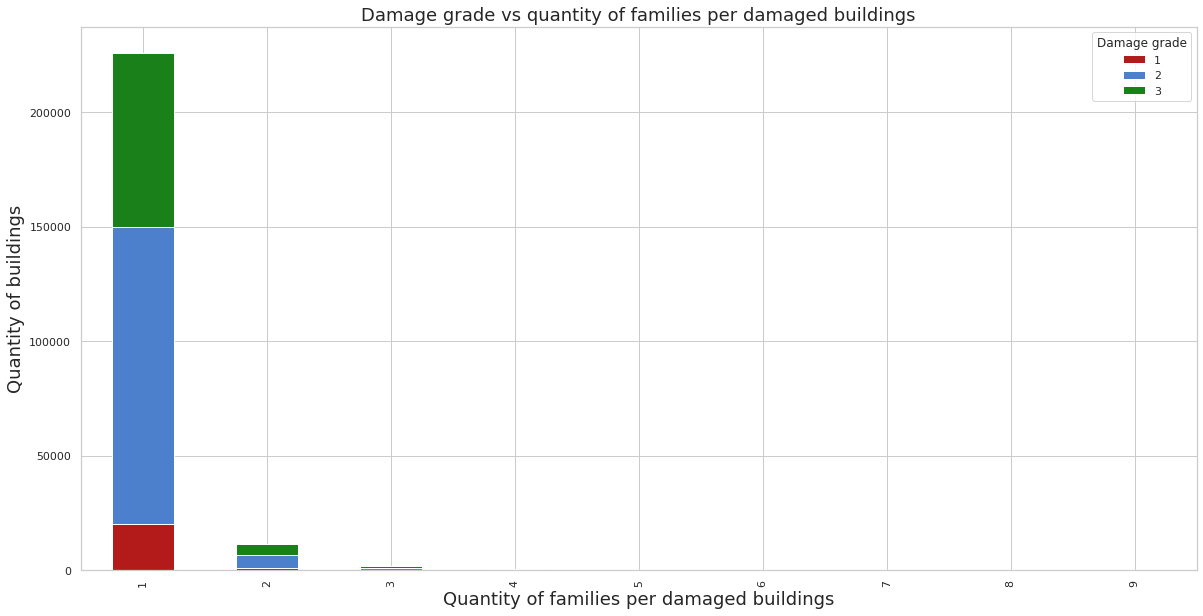

In [139]:
plot = affected_buildings_pivot.plot.bar(color=[(0.7, 0.1, 0.1), (0.3, 0.5, 0.8), (0.1, 0.5, 0.1)], stacked=True, figsize=(20,10))
plot.set_title("Damage grade vs quantity of families per damaged buildings", fontsize=18)
plot.set_ylabel("Quantity of buildings", fontsize=18);
plot.set_xlabel("Quantity of families per damaged buildings", fontsize=18);

A partir de este gráfico, observamos que la mayor cantidad de familias afectadas se encunetran en los edificios en donde vivía solamente una familia, seguido de los edificios donde vivían dos familias. En ambos casos, la mayoría del daño de los edificos fue nivel dos y luego nivel tres, por lo que, la mayor cantidad de las familias de las zonas afectadas por el terremoto, tuvieron que refaccionar sus hogares y/o abandonarlos.

La distribución de los datos analizados en el gráfico anterior nos lleva a analizar cómo se distribuyen los edificios en donde viven una y dos o más familias en las tres zonas geográficas.

 A continuación, veremos los daños que recibieron los edificios donde vivía una sola familia en las tres regiones:



*   Región 1



In [13]:
affected_buildings_where_lives_1_family = train_values_reduced_with_damage_for_affected_families.loc[train_values_reduced_with_damage_for_affected_families['count_families'] == 1, :]

In [14]:
affected_buildings_where_lives_1_family_region_1 = affected_buildings_where_lives_1_family.groupby(['geo_level_1_id', 'damage_grade']).agg({'damage_grade':'count'})
affected_buildings_where_lives_1_family_region_1.columns = ['damage_grade_count']
affected_buildings_where_lives_1_family_region_1.reset_index(inplace=True)
affected_buildings_where_lives_1_family_region_1.columns = ['Region 1', 'Damage grade', 'Damage grade count']
affected_buildings_where_lives_1_family_region_1.head()

,Region 1,Damage grade,Damage grade count
0,0,1,320
1,0,2,3000
2,0,3,589
3,1,1,390
4,1,2,1921


In [100]:
affected_buildings_where_lives_1_family_region_1_pivot = affected_buildings_where_lives_1_family_region_1.pivot(index='Region 1', columns='Damage grade', values='Damage grade count')
affected_buildings_where_lives_1_family_region_1_pivot = affected_buildings_where_lives_1_family_region_1_pivot.fillna(0)
affected_buildings_where_lives_1_family_region_1_pivot.head()

Damage grade,1,2,3
Region 1,,,
0,320.00,"3,000.00",589.00
1,390.00,"1,921.00",302.00
2,78.00,570.00,230.00
3,125.00,"4,079.00","2,544.00"
4,412.00,"9,474.00","2,450.00"


In [101]:
total = affected_buildings_where_lives_1_family_region_1_pivot[1] + affected_buildings_where_lives_1_family_region_1_pivot[2] + affected_buildings_where_lives_1_family_region_1_pivot[3]
affected_buildings_where_lives_1_family_region_1_pivot[1] = affected_buildings_where_lives_1_family_region_1_pivot[1]/total
affected_buildings_where_lives_1_family_region_1_pivot[2] = affected_buildings_where_lives_1_family_region_1_pivot[2]/total
affected_buildings_where_lives_1_family_region_1_pivot[3] = affected_buildings_where_lives_1_family_region_1_pivot[3]/total
affected_buildings_where_lives_1_family_region_1_pivot.head()

Damage grade,1,2,3
Region 1,,,
0,0.08,0.77,0.15
1,0.15,0.74,0.12
2,0.09,0.65,0.26
3,0.02,0.60,0.38
4,0.03,0.77,0.20


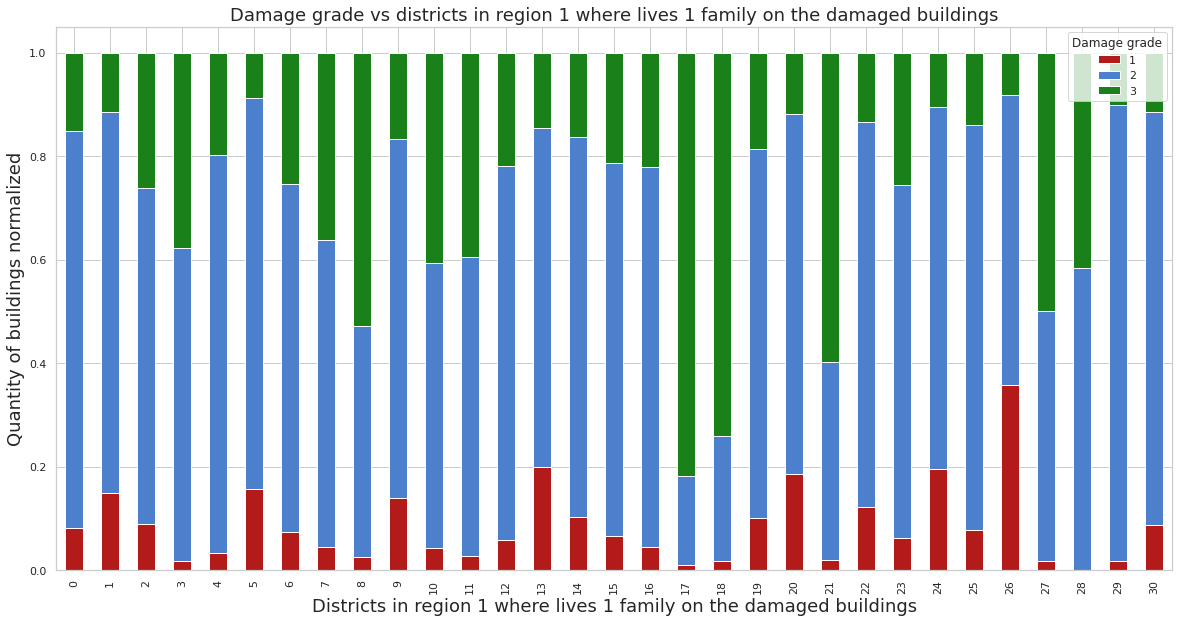

In [138]:
plot = affected_buildings_where_lives_1_family_region_1_pivot.plot.bar(color=[(0.7, 0.1, 0.1), (0.3, 0.5, 0.8), (0.1, 0.5, 0.1)],stacked=True, figsize=(20,10))
plot.set_title("Damage grade vs districts in region 1 where lives 1 family on the damaged buildings", fontsize=18)
plot.set_ylabel("Quantity of buildings normalized", fontsize=18);
plot.set_xlabel("Districts in region 1 where lives 1 family on the damaged buildings", fontsize=18);

Tuvimos que normalizar los datos para poder visualizar más concretamente los edificios (nos abstraemos de qué zona de la región uno es la más poblada) que fueron dañados en la región uno y que vivía solamente una familia. De esta forma, es fácil comparar qué tan dañados resultaron los edificios de la región uno por sus distritos. Como conclusión, decimos que se observa claramente que los edificios del distrito 17 y 18 son los que fueron más dañados, por lo que las familias de esos distritos perdieron sus hogares (destrucción total).



*   Región 2




In [142]:
affected_buildings_where_lives_1_family_region_2 = affected_buildings_where_lives_1_family.groupby('geo_level_2_id').agg({'damage_grade':'mean'})
affected_buildings_where_lives_1_family_region_2.columns = ['damage_grade_mean']
affected_buildings_where_lives_1_family_region_2.reset_index(inplace=True)
affected_buildings_where_lives_1_family_region_2.columns = ['Region 2', 'Damage grade mean']
affected_buildings_where_lives_1_family_region_2.head()

,Region 2,Damage grade mean
0,0,3.00
1,1,2.37
2,3,2.10
3,4,2.54
4,5,2.16


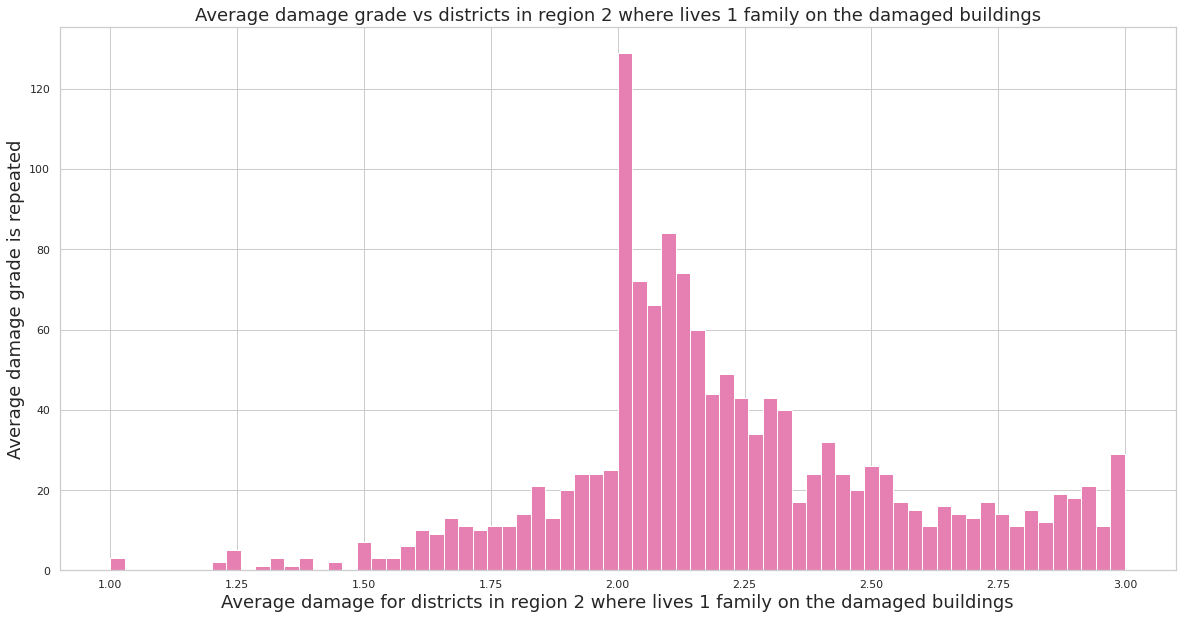

In [147]:
plot = affected_buildings_where_lives_1_family_region_2['Damage grade mean'].plot.hist(color=(0.9, 0.5, 0.7), bins=70, figsize=(20,10))
plot.set_title("Average damage grade vs districts in region 2 where lives 1 family on the damaged buildings", fontsize=18)
plot.set_ylabel("Average damage grade is repeated", fontsize=18);
plot.set_xlabel("Average damage for districts in region 2 where lives 1 family on the damaged buildings", fontsize=18);

**Conclusión**



*   Region 3



In [104]:
affected_buildings_where_lives_1_family_region_3 = affected_buildings_where_lives_1_family.groupby('geo_level_3_id').agg({'damage_grade':'mean'})
affected_buildings_where_lives_1_family_region_3.columns = ['damage_grade_mean']
affected_buildings_where_lives_1_family_region_3.reset_index(inplace=True)
affected_buildings_where_lives_1_family_region_3.columns = ['Region 3', 'Damage grade mean']
affected_buildings_where_lives_1_family_region_3.head()

,Region 3,Damage grade mean
0,0,3.00
1,1,2.50
2,3,1.88
3,5,1.15
4,6,2.68


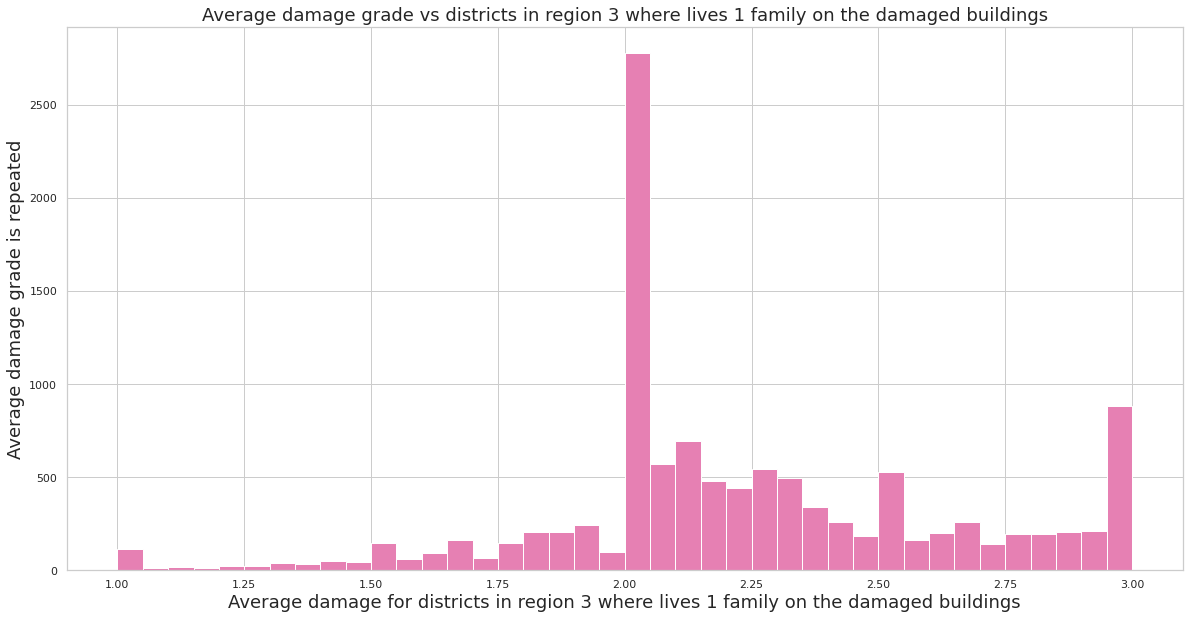

In [148]:
plot = affected_buildings_where_lives_1_family_region_3['Damage grade mean'].plot.hist(color=(0.9, 0.5, 0.7), bins=40, figsize=(20,10))
plot.set_title("Average damage grade vs districts in region 3 where lives 1 family on the damaged buildings", fontsize=18)
plot.set_ylabel("Average damage grade is repeated", fontsize=18);
plot.set_xlabel("Average damage for districts in region 3 where lives 1 family on the damaged buildings", fontsize=18);

**Conclusión**

#Edificios de uso secundario

Análisis previo:

In [ ]:
train_values['has_secondary_use'].value_counts()

0    231445
1     29156
Name: has_secondary_use, dtype: int64

In [ ]:
train_values['has_secondary_use_other'].value_counts()

0    259267
1      1334
Name: has_secondary_use_other, dtype: int64

In [ ]:
train_values['has_secondary_use_use_police'].value_counts()

0    260578
1        23
Name: has_secondary_use_use_police, dtype: int64

In [ ]:
train_values['has_secondary_use_gov_office'].value_counts()

0    260563
1        38
Name: has_secondary_use_gov_office, dtype: int64

In [ ]:
train_values['has_secondary_use_health_post'].value_counts()

0    260552
1        49
Name: has_secondary_use_health_post, dtype: int64

In [ ]:
train_values['has_secondary_use_industry'].value_counts()

0    260322
1       279
Name: has_secondary_use_industry, dtype: int64

In [ ]:
train_values['has_secondary_use_school'].value_counts()

0    260507
1        94
Name: has_secondary_use_school, dtype: int64

In [ ]:
train_values['has_secondary_use_institution'].value_counts()

0    260356
1       245
Name: has_secondary_use_institution, dtype: int64

In [ ]:
train_values['has_secondary_use_rental'].value_counts()

0    258490
1      2111
Name: has_secondary_use_rental, dtype: int64

In [ ]:
train_values['has_secondary_use_hotel'].value_counts()

0    251838
1      8763
Name: has_secondary_use_hotel, dtype: int64

In [ ]:
train_values['has_secondary_use_agriculture'].value_counts()

0    243824
1     16777
Name: has_secondary_use_agriculture, dtype: int64

Haciendo la suma de todas las ocurrencias de los unos que figuran en cada columna has_secondary_use_x (x puede ser agriculture, hotel, rental, institution, school, industry, health_post, gov_office, police y other), 29713, vemos que es mayor a todos los unos de la columna has_secondary_use, 29156. Eso es debido a que un edificio puede tener más de un eso secundario. A continuación se detalla un ejemplo:

In [ ]:
train_values.loc[train_values['has_secondary_use_agriculture'].eq(1) & train_values['has_secondary_use_other'].eq(1), :].shape

(474, 39)